In [117]:
# Import libraries
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings

In [ ]:
import os 
cwd = os.getcwd()

'/Users/adeel/GenAI_Chatbot/University-Course-Books-Chatbot-GENAI'

In [57]:
# Extracting data from pdf file
loader= DirectoryLoader('/Users/adeel/GenAI_Chatbot/University-Course-Books-Chatbot-GENAI', glob="*.pdf",loader_cls=PyPDFLoader)
documents=loader.load() 

Ignoring wrong pointing object 150 0 (offset 0)
Ignoring wrong pointing object 423 0 (offset 0)
Ignoring wrong pointing object 530 0 (offset 0)
Ignoring wrong pointing object 577 0 (offset 0)
Ignoring wrong pointing object 613 0 (offset 0)
Ignoring wrong pointing object 820 0 (offset 0)
Ignoring wrong pointing object 1096 0 (offset 0)
Ignoring wrong pointing object 1108 0 (offset 0)
Ignoring wrong pointing object 1120 0 (offset 0)
Ignoring wrong pointing object 1161 0 (offset 0)
Ignoring wrong pointing object 1175 0 (offset 0)
Ignoring wrong pointing object 1178 0 (offset 0)
Ignoring wrong pointing object 1181 0 (offset 0)
Ignoring wrong pointing object 1184 0 (offset 0)
Ignoring wrong pointing object 1186 0 (offset 0)
Ignoring wrong pointing object 1305 0 (offset 0)
Ignoring wrong pointing object 1351 0 (offset 0)
Ignoring wrong pointing object 1698 0 (offset 0)
Ignoring wrong pointing object 1810 0 (offset 0)
Ignoring wrong pointing object 2083 0 (offset 0)
Ignoring wrong pointing ob

In [98]:
test = documents[201:204]
test

[Document(metadata={'producer': 'pdfTeX-1.40.20', 'creator': 'LaTeX with hyperref', 'creationdate': '2021-01-05T12:49:26-06:00', 'author': '', 'title': '', 'subject': '', 'keywords': '', 'moddate': '2021-01-05T12:49:26-06:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) kpathsea version 6.3.1', 'source': '/Users/adeel/GenAI_Chatbot/University-Course-Books-Chatbot-GENAI/MachineLearning.pdf', 'total_pages': 389, 'page': 201, 'page_label': '202'}, page_content='202 Chapter 13. Clustering\nFinally, the output shows the components you can look at within the irisCluster object. For\nexample to see the size, type irisCluster$size at the console. Most of this information\nwas already supplied in the output.\n13.3 Metrics\nIn most clustering problems we are clustering without knowing what the "true" clustering\nshould be, or if there even is a "true" clustering. How will you know if you have a good\nclustering or not? Let’s ﬁrst look m

##### There are images in the book, so which text splitter should we use?

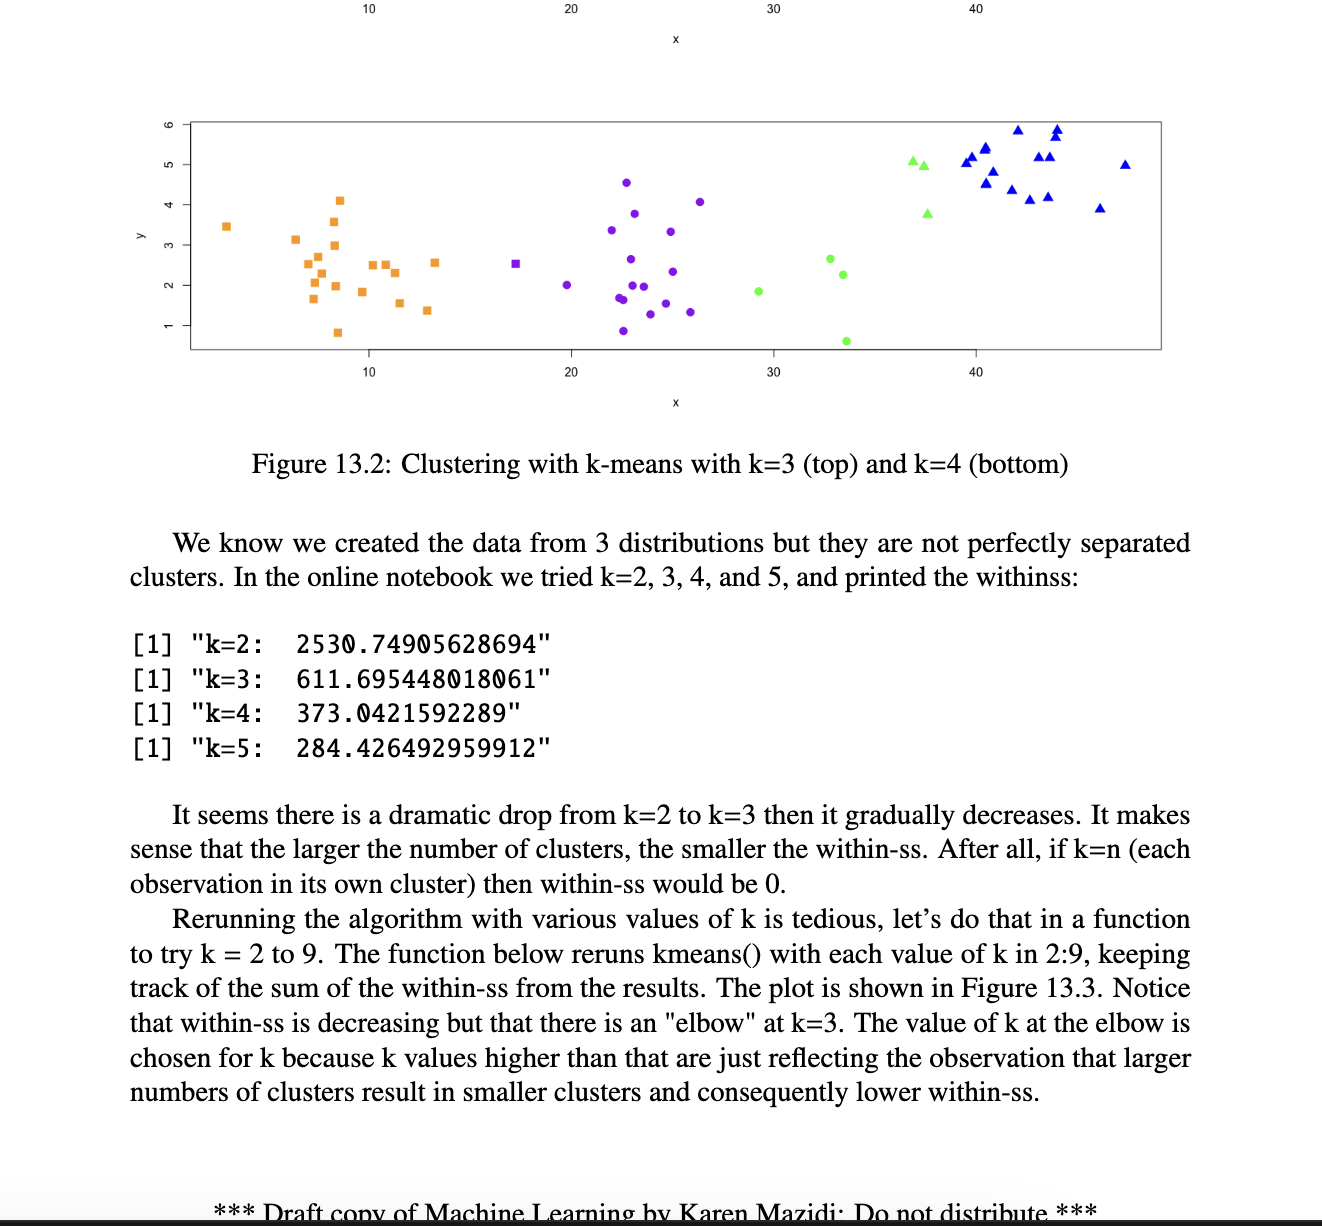

In [99]:
#split data into chunks
def text_split(extracted_data):
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=35)
    text_chunks=text_splitter.split_documents(extracted_data)
    return text_chunks

In [100]:
text_chunks=text_split(test)
print("Length of Text Chunks", len(text_chunks))

Length of Text Chunks 13


#### We can see that it did not pick up the image in the book

In [104]:
text_chunks[12].page_content

'numbers of clusters result in smaller clusters and consequently lower within-ss.\n*** Draft copy of Machine Learning by Karen Mazidi: Do not distribute ***'

#### Data is splitted as chunks using recursive text splitter

In [105]:
text_chunks=text_split(documents)
print("Length of Text Chunks", len(text_chunks))

Length of Text Chunks 6810


In [144]:
# Convert chunks into embeddings using a model from HuggingFace
def download_hugging_face_embeddings():
    embeddings=HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
    return embeddings

In [145]:
from sentence_transformers import SentenceTransformer
embeddings = download_hugging_face_embeddings()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [ ]:
# embedding vector dimmension
len(embeddings.embed_query('Linear regression'))

384

In [180]:
# Getting the pinecone key to store embeddings into database
from dotenv import load_dotenv
import os
load_dotenv()

key = os.environ.get('PINECONE_API_KEY') 

In [181]:
os.environ['PINECONE_API_KEY'] = key

In [159]:
from langchain_pinecone import PineconeVectorStore

docsearch = PineconeVectorStore.from_documents(
    documents=text_chunks,
    index_name='llmcoursebook',
    embedding=embeddings, 
)

In [160]:
# Load existing index 
search = PineconeVectorStore.from_existing_index(
    index_name='llmcoursebook',
    embedding=embeddings
)

In [162]:
retriever = search.as_retriever(search_type="similarity", search_kwargs={"k":3})

In [ ]:
# Testing the answer from trained data
retrieved_docs = retriever.invoke("What is recall?")
retrieved_docs

[Document(id='9cf05603-51d0-424a-953e-9f0848236424', metadata={'author': '', 'creationdate': '2021-01-05T12:49:26-06:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2021-01-05T12:49:26-06:00', 'page': 299.0, 'page_label': '300', 'producer': 'pdfTeX-1.40.20', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) kpathsea version 6.3.1', 'source': '/Users/adeel/GenAI_Chatbot/University-Course-Books-Chatbot-GENAI/MachineLearning.pdf', 'subject': '', 'title': '', 'total_pages': 389.0, 'trapped': '/False'}, page_content='report. The report is shown below the code block.\nIn the report, the precision, recall, and f1 scores are broken down by class. Recall from\nearlier chapters that precision is the true positives divided by (true positives plus false positives).\nThe recall is the true positives divided by (true positives plus false negatives). The f1 metric is\nthe harmonic mean between precision and recall. The support column gives the numbe

In [ ]:
load_dotenv()
OPENAI_API_KEY=os.environ.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [218]:
# Integrating the vector db to a LLM
from langchain_openai import OpenAI
llm = OpenAI(temperature=0.4, max_tokens=500)

In [ ]:
# Prompt engineering 

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate


system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [221]:
# Creating Chain 
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [222]:
# Testing LLM 
response = rag_chain.invoke({"input": "what is the difference between Precision and recall?"})

In [223]:
print(response["answer"])



Precision is a measure of how many of the predicted positive cases are actually positive, while recall is a measure of how many of the actual positive cases were correctly predicted. In other words, precision focuses on the accuracy of positive predictions, while recall focuses on the completeness of positive predictions. They are both important metrics in evaluating classification results.


In [226]:
response_irrelevant = rag_chain.invoke({"input": "who won NBA championship in 2011?"})

In [227]:
print(response_irrelevant["answer"])



I don't know.


In [228]:
response_database = rag_chain.invoke({"input": "what is a primary key?"})

In [229]:
print(response_database["answer"])



A primary key is a unique identifier that is chosen with care to represent a constraint in the real-world enterprise being modeled. It must be unique and stable, and is often chosen based on attributes that are guaranteed to never change, such as a social-security number. It is a special case of a functional dependency and is used to uniquely identify records in a database.


In [230]:
response_database

{'input': 'what is a primary key?',
 'context': [Document(id='cb6ced56-1b20-4fa1-99f1-36f5f6f2af4a', metadata={'author': 'Ayan Kumar Chatterjee', 'creationdate': '2017-12-05T08:14:35+00:00', 'creator': 'Microsoft® Office Word 2007', 'moddate': '2017-12-18T15:27:34+05:30', 'page': 28.0, 'page_label': '29', 'producer': 'Microsoft® Office Word 2007', 'source': '/Users/adeel/GenAI_Chatbot/University-Course-Books-Chatbot-GENAI/DATABASE MANAGEMENT SYSTEMS.pdf', 'total_pages': 232.0}, page_content='from having the same value on the key attributes at the  same time. The designation of a key represents a \nconstraint in the real-world enterprise being modeled. \n \nPrimary keys must be c hosen with care. As we noted, the name of a person is  obviously not sufficient, because \nthere may be many people with the same name.  In the United States, the social -security number attribute of a \nperson would be  a candidate key. Since non -U.S. residents u sually do not have social -security numbers, \